# Title: Impact of Network Size on Metrics
## Purpose: Explore effects of scaling model size on metric output
## @author: mjz

## Background




In [89]:
%matplotlib inline

#------ python libs ----------
import logging
import os
SEP = os.path.sep
import sys
import uuid
import pathlib

#------ notebook libs ----------
import matplotlib.pyplot as plt
import networkx as nx
import graphviz
import IPython.display
import numpy as np
# import scipy.stats as st
# import scipy.special
# # bokeh plotting setup
# import bokeh.io
# import bokeh.plotting
# import bokeh.application
# import bokeh.application.handlers
# bokeh.io.output_notebook()
# notebook_url = 'localhost:8888'

import os
from google.cloud import bigquery
%reload_ext google.cloud.bigquery

import pandas as pd
import pandas_gbq


#------ project libs ----------
py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

# Just importing for their flags right now
import py_mulval.py_mulval as py_mulval
import py_mulval.boromir as boromir
import py_mulval.log_util as log_util
import py_mulval.mulpy as mulpy
import py_mulval.metrics as secmet
import py_mulval.attack_graph as attack_graph
from py_mulval.mulval_fact_graph import FactGraph
from py_mulval.attack_graph import AttackGraph

from py_mulval import flags
FLAGS = flags.FLAGS
FLAGS([sys.argv[0]]) # dont expect cli args from jupyter

['/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/ipykernel_launcher.py']

In [90]:
# Show an dot graph in this notebook
def plot_dot(ag, title=None):
    A = nx.nx_agraph.to_agraph(ag)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

# from IPython.display import Image, display
# def plot_dot(pdot):
#     plt = Image(pdot.create_png())
#     display(plt)

## Assumptions

In [ ]:
%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py --input_file=small_enterprise.P --benchmarks=mttf --secmet_random_cvss_score --secmet_map_scores=cvss2time --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

## Setup

We can run boromir with the following command and specify sample paramaters on the cli:

`/opt/projects/diss/py-mulval/src/run_boromir.py --input_file=small_enterprise.P --benchmarks=mttf --secmet_random_cvss_score --secmet_map_scores=cvss2time --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='<project>:<dataset>.<table>'`


or pass them in a config file:
mttf.yml:
```
mttf:
    flags:
        # secmet_score_strategy: 'reliability'
        secmet_plot_intermediate_graphs: False
        secmet_random_cvss_score: True
```

Using the mttf.yml file helps us track runs with version control systems, but all flags can be specified at the command line as well. `--secmet_random_cvss_score=True` and `--boromir_run_count=1000` create 1000 samples with vulnerability scores chosen from a uniform random distribution in `[0.0, 10.0]` to represent a CVSS score. Other distributions and intervals can be defined as well. `--input_file=small_enterprise.P` is just what we've named the small reference model used up to now for demonstration. We run collect another  1000 samples against our large(r) model in the next cell.

The flag `--bigquery_table='cloud-performance-tool:test_notebook_bq.test1'` tells boromir where to publish the results. If no publishing target is specified the results are stored as json in the $TMP directory. Influxdb setup is covered in notebook `000_influxdb_setup.ipynb`.



In [ ]:
%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py --input_file=large_enterprise.P --benchmarks=mttf --secmet_random_cvss_score --secmet_map_scores=cvss2time --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

Each run generates a uuid which can be used as select criteria to get samples from a single run. Here we have `be421189` for the small samples and the large run is `90cd0da1`

In [9]:
%%bigquery df_small
# SELECT thedate, sample_uri, test, value, metric,
SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph,
metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,

  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
    and run_uri = 'be421189'
#      order by timestamp asc
#      limit 1
     ) 

In [10]:
%%bigquery df_large
# SELECT thedate, sample_uri, test, value, metric,
SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph,
metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,

  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
    and run_uri = '90cd0da1'
#      order by timestamp asc
#      limit 1
     ) 

In [11]:
df_small.describe()

,value
count,1000.000000
mean,33.380245
std,32.869406
min,0.002800
25%,5.200599
50%,15.289103
75%,55.040099
max,150.200000


In [12]:
df_large.describe()

,value
count,1000.000000
mean,6.425505
std,13.889754
min,0.000224
25%,0.029094
50%,0.304801
75%,3.550439
max,49.997801


## Effects of Network Size on Metric Behaviour

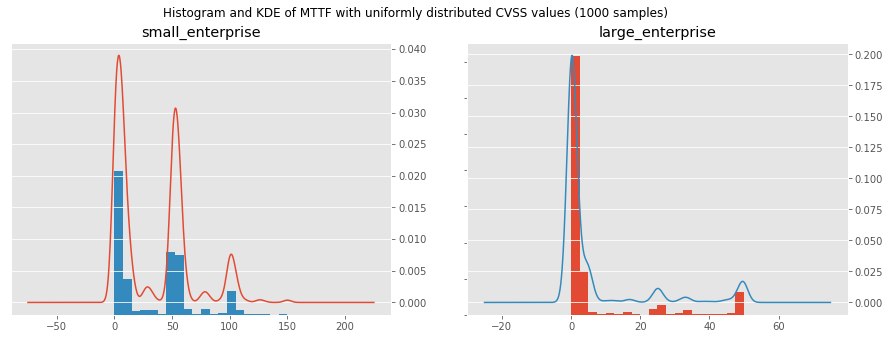

<Figure size 1080x360 with 0 Axes>

In [66]:
# Start by just plotting what we previously grouped!
# plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
plt.figure(figsize=(15,5), )

# ax1 = plt.subplot(1,3,1)
# ax1.plot.hist(df_small.value, bins=20)
df_small.value.plot.kde(bw_method=0.1, secondary_y=True, ax=ax1)
ax1.title.set_text('small_enterprise')
ax1.hist(df_small.value, bins=20,)
# ax1.kde(df_small.value, bw_method=0.1, secondary_y=True)

# plt.subplot(1,3,2)
# df_small.value.plot.kde(bw_method=0.2)

# ax2 = plt.subplot(1,3,2)
ax2.hist(df_large.value, bins=20)
df_large.value.plot.kde(bw_method=0.1, secondary_y=True, ax=ax2)
ax2.title.set_text('large_enterprise')

fig.suptitle('Histogram and KDE of MTTF with uniformly distributed CVSS values (1000 samples)')

plt.show()

In [45]:
# Show an attack graph in this notebook
def plot_ag(ag, title=None):
    A = nx.nx_agraph.to_agraph(ag)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

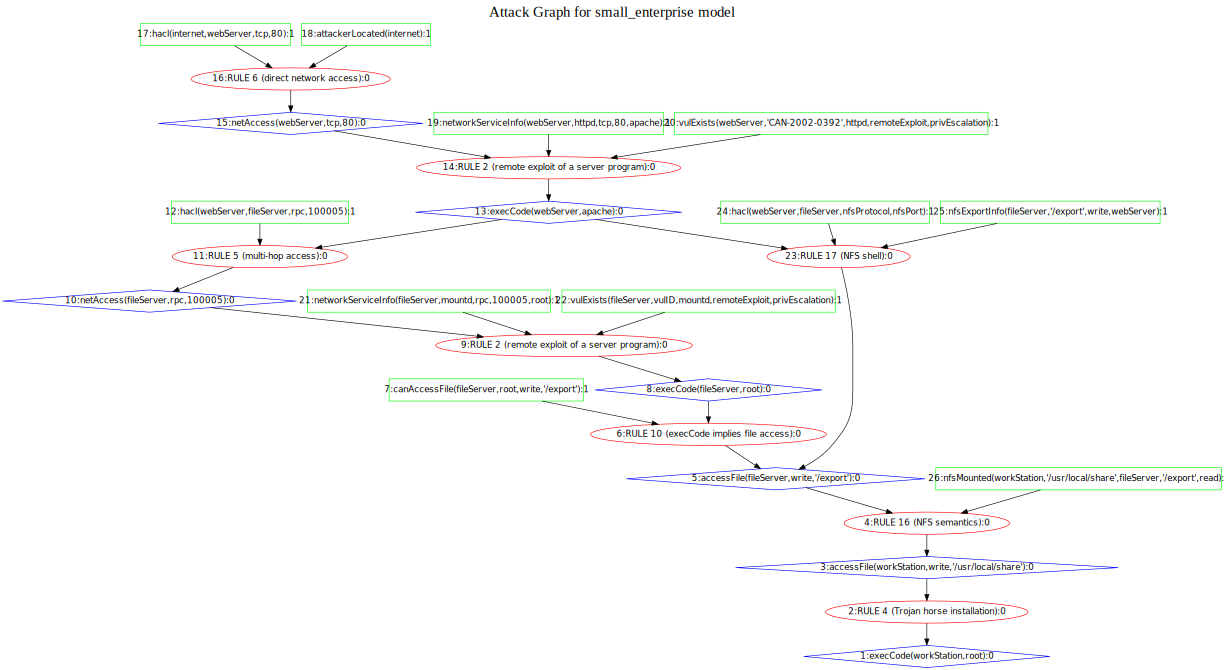

In [53]:
ag_small = AttackGraph()
ag_small.load_dot_file('/tmp/mulpy/runs/be421189/AttackGraph.dot')
ag_small.name = 'small_enterprise'
plot_ag(ag_small, 'Attack Graph for small_enterprise model')




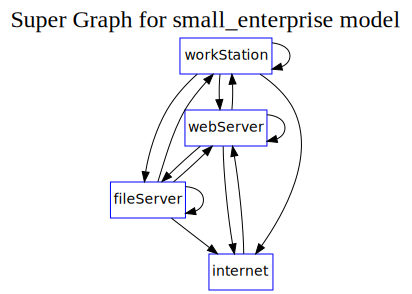

In [71]:
fg_small = FactGraph()
fg_small.load_json_file('/tmp/mulpy/runs/be421189/mulval_facts.json')
fg_small.name = 'small_enterprise'
plot_ag(fg_small, 'Host Graph for small_enterprise model')

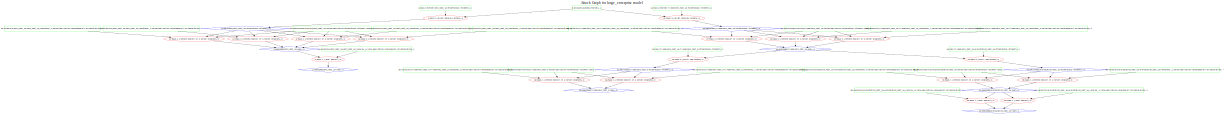

In [54]:
ag_large = AttackGraph()
ag_large.load_dot_file('/tmp/mulpy/runs/90cd0da1/AttackGraph.dot')
ag_large.name = 'large_enterprise'

plot_ag(ag_large, 'Attack Graph for large_enterprise model')

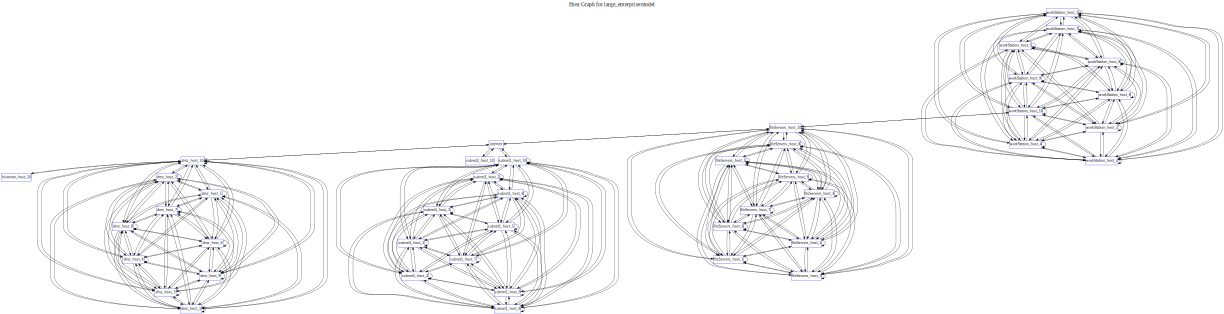

In [72]:
fg_large = FactGraph()
fg_large.load_json_file('/tmp/mulpy/runs/90cd0da1/mulval_facts.json')
fg_large.name = 'small_enterprise'
plot_ag(fg_large, 'Host Graph for large_enterprise model')

Text(0.5, 0.98, 'Attack graphs for each network')

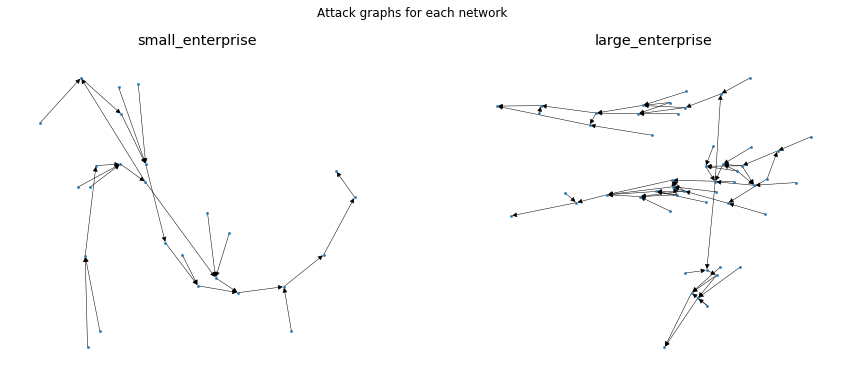

In [69]:


fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
nx.draw_networkx(ag_small, ax=ax1, with_labels=False,
                 node_size=5, width=.5)
ax1.title.set_text('small_enterprise')
ax1.set_axis_off()


nx.draw_networkx(ag_large, ax=ax2, with_labels=False,
                 node_size=5, width=.5)
ax2.set_axis_off()

ax2.title.set_text('large_enterprise')

fig.suptitle('Attack graphs for each network')

In [85]:
df_small.head()

,sample_uri,reduced_ag,value,orig_ag,fact_graph,metric
0,d3cf89f1-4d22-4b8c-b46a-090856bfbff8,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,8.0,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,None,mttf
1,e4dbc829-29be-4239-a3de-3b971e1bc7f2,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,12.0,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,None,mttf
2,1a70a3e8-f755-41b8-8874-40f54996b1a6,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,16.0,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,None,mttf
3,d4c9c10c-0e50-4a60-a7a1-c62fff3acbf3,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,65.0,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,None,mttf
4,40f93239-badf-4818-a673-0c47d60df777,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,81.5,digraph G {\n\tgraph [name=G];\n\t1\t [color=b...,None,mttf


In [76]:
df_small[df_small['metric']=='mttf'].describe()

,value
count,1000.000000
mean,33.380245
std,32.869406
min,0.002800
25%,5.200599
50%,15.289103
75%,55.040099
max,150.200000


In [77]:
df_small[df_small['metric']=='mttf'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
sample_uri    1000 non-null object
reduced_ag    1000 non-null object
value         1000 non-null float64
orig_ag       1000 non-null object
fact_graph    1000 non-null object
metric        1000 non-null object
dtypes: float64(1), object(5)
memory usage: 54.7+ KB


We can see how these values fall within our experimental range by fixing the lower and upper bounds of security for this topology with the following configuration (`mttf_step_cvss.yml`):

```
mttf:
    flag_matrix: fmatrix
    flag_matrix_defs:
        fmatrix:
            secmet_fix_cvss_score: [1, 2, 3, 4, 5, 6,  7, 8, 9, 10]
    flags:
        secmet_plot_intermediate_graphs: False
        secmet_map_scores: 'cvss2time'
```

In [81]:
np.linspace(0.0, 10.0, 101)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

## Fixed score stepping for validation

We can generate incremental increases in security by stepping the weights that influence a security metric. Here we assume CVSS base scores are the range of weights (0-10) so we examine how our metric behaves across that range over 100 steps.


In [83]:
! cat /opt/projects/diss/py-mulval/src/py_mulval/configs/mttf_step_cvss_100.yml

mttf:
    flag_matrix: fmatrix
    flag_matrix_defs:
        fmatrix:
#            input_file: ['small_enterprise.P', 'large_enterprise.P']
#            rule: ['local_exploit_rules.P']
#            secmet_map_scores: [ 'cvss2time', 'cvss2effort']
            secmet_fix_cvss_score: [ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
                                     1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
                                     2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
                                     3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
                                     4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
                                     5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
                                     6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
                                     7.

### Generate datasets for stepped security below. 
(we could run any combination of flags as shown in the flag matrix above, but it's simpler to split apart sample sets by uuid for these examples)

In [ ]:
%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py  --benchmarks=mttf --input_file=small_enterprise.P --secmet_random_cvss_score --secmet_map_scores=cvss2time --benchmark_config_file=mttf_step_cvss_100.yml --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

In [ ]:
%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py  --benchmarks=mttf --input_file=large_enterprise.P  --secmet_map_scores=cvss2time --benchmark_config_file=mttf_step_cvss_100.yml --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

### 637c3b21 small_enterprise_fixed
### 7974bda4 large_enterprise_fixed


### Query fixed score date into pandas

In [99]:
%%bigquery df_fixed_small

# SELECT thedate, sample_uri, test, value, metric,
SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph, fixed_score,
metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|secmet_fix_cvss_score:(.*?)\|') AS fixed_score,

  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
    and run_uri = '637c3b21'
#      order by timestamp asc
#      limit 1
     ) 

In [100]:
df_fixed_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
sample_uri     101 non-null object
reduced_ag     101 non-null object
value          101 non-null float64
orig_ag        101 non-null object
fact_graph     101 non-null object
fixed_score    101 non-null object
metric         101 non-null object
dtypes: float64(1), object(6)
memory usage: 5.6+ KB


In [101]:
%%bigquery df_fixed_large

# SELECT thedate, sample_uri, test, value, metric,
SELECT sample_uri, reduced_ag, value, orig_ag, fact_graph, fixed_score,
metric,

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,
    REGEXP_EXTRACT(labels, r'(?s)\|secmet_fix_cvss_score:(.*?)\|') AS fixed_score,
    

  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
    and run_uri = '7974bda4'
#      order by timestamp asc
#      limit 1
     ) 

In [102]:
df_fixed_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
sample_uri     101 non-null object
reduced_ag     101 non-null object
value          101 non-null float64
orig_ag        101 non-null object
fact_graph     101 non-null object
fixed_score    101 non-null object
metric         101 non-null object
dtypes: float64(1), object(6)
memory usage: 5.6+ KB


In [115]:
## fixed score came back as string
df_fixed_small.fixed_score = df_fixed_small.fixed_score.astype(float)

df_fixed_large.fixed_score = df_fixed_large.fixed_score.astype(float)



In [119]:
df_fixed_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
sample_uri     101 non-null object
reduced_ag     101 non-null object
value          101 non-null float64
orig_ag        101 non-null object
fact_graph     101 non-null object
fixed_score    101 non-null float64
metric         101 non-null object
dtypes: float64(2), object(5)
memory usage: 5.6+ KB


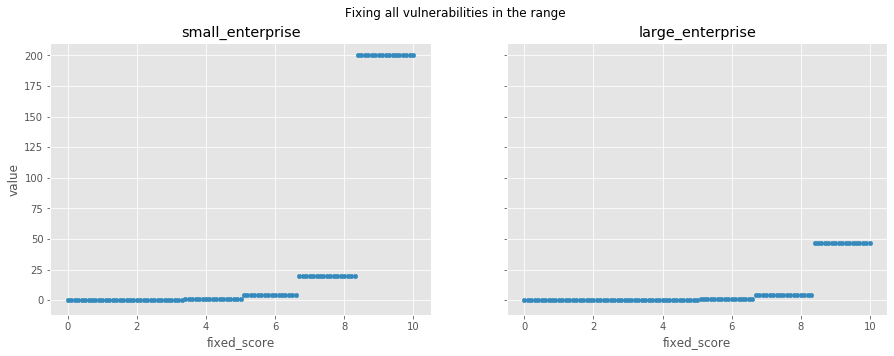

<Figure size 1080x360 with 0 Axes>

In [190]:
# Start by just plotting what we previously grouped!
# plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
plt.figure(figsize=(15,5), )

df_fixed_small.plot( x='fixed_score' , y='value', kind='scatter', ax=ax1)
ax1.title.set_text('small_enterprise')


df_fixed_large.plot(x='fixed_score' , y='value', kind='scatter', ax=ax2)
ax2.title.set_text('large_enterprise')

fig.suptitle('Fixing all vulnerabilities in the range')

plt.show()

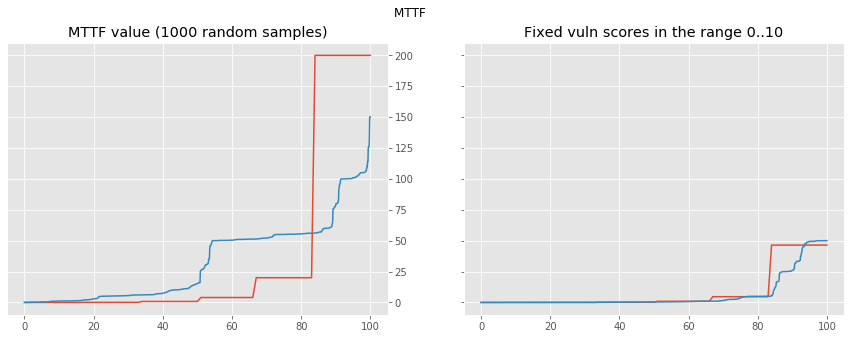

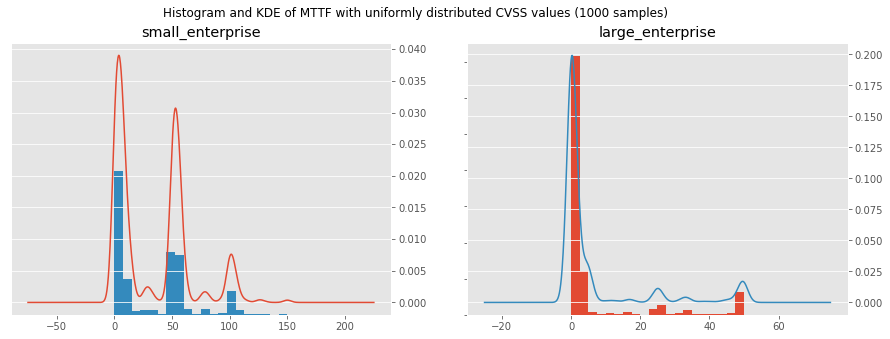

<Figure size 1080x360 with 0 Axes>

In [214]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))


ax1.plot(df_fixed_small['value'])
ax1.set_title('MTTF value (1000 random samples)')
ax1.yaxis.tick_right()
order_small = np.argsort(df_small['value'])
xsmall  = np.linspace(0.0, 100.0, 1000)
ysmall = np.array(df_small['value'])[order_small]
ax1.plot(xsmall, ysmall)
# ax1.set_yticks([']) 

ax2.plot(df_fixed_large['value'])
ax2.set_title('Fixed vuln scores in the range 0..10')
order = np.argsort(df_large['value'])
xs  = np.linspace(0.0, 100.0, 1000)
ys = np.array(df_large['value'])[order]
ax2.plot(xs, ys)

fig.suptitle('MTTF ')


ax2.hist(df_large.value, bins=20)
df_large.value.plot.kde(bw_method=0.1, secondary_y=True, ax=ax2)
ax2.title.set_text('large_enterprise')

fig.suptitle('Histogram and KDE of MTTF with uniformly distributed CVSS values (1000 samples)')

plt.show()


So out of 1000 samples, our average time to compromise is ~34 weeks. 

### Functions for extracting data from graphs

In [157]:


def dot2adj(dot_str, weight='score', nodelist=None):
    """Reads a dot graph file, converts to adj matrix"""
    g = AttackGraph()
    g.load_dot_string(dot_str)
    nl  = nodelist
    if not nl:
        nl = list(nx.topological_sort(g))
#     print(g.nodes(), nl)
    A = np.squeeze(np.asarray(nx.to_numpy_matrix(g, nodelist=nl, weight=weight).flatten()))
#     print(A.shape, type(A))
    return A
    

def row2adj(dot_str_row, dotcol='reduced_ag', weight='score', nodelist=None):
    """Reads a dot graph file, converts to adj matrix"""
    g = None
    if dotcol == 'fact_graph':
        g = FactGraph()
    else:
        g = AttackGraph()
    g.load_dot_string(dot_str_row[dotcol])
    nl  = nodelist
    if not nl:
        nl = list(nx.topological_sort(g))
#     print(g.nodes(), nl)
    A = np.squeeze(np.asarray(nx.to_numpy_matrix(g, nodelist=nl, weight=weight).flatten()))
#     print(A.shape, type(A))
    x =  A.tolist() # :/ 
    y = [dot_str_row.sample_uri] + x +[dot_str_row.value]
#     print(type(y), y)
    return y


def flatNodeList(nodelist):
    fnl = []
    for i in range(len(nodelist)):
        for j in range(len(nodelist)):
            fnl.append('w_{}_{}'.format(i,j))
    return fnl
    
    

### Load a graph from db

In [159]:
ag_reduced_small= AttackGraph()
dots = df_small['reduced_ag'].values[0]
ag_reduced_small.load_dot_string(dots)
nodelist = list(nx.topological_sort(ag_reduced_small))
# print(nodelist)
fnl = flatNodeList(nodelist)
print(fnl)
# print(dots)
a = dot2adj(dots, weight='score_orig')
# print(type(a), a)




['w_0_0', 'w_0_1', 'w_0_2', 'w_0_3', 'w_0_4', 'w_0_5', 'w_1_0', 'w_1_1', 'w_1_2', 'w_1_3', 'w_1_4', 'w_1_5', 'w_2_0', 'w_2_1', 'w_2_2', 'w_2_3', 'w_2_4', 'w_2_5', 'w_3_0', 'w_3_1', 'w_3_2', 'w_3_3', 'w_3_4', 'w_3_5', 'w_4_0', 'w_4_1', 'w_4_2', 'w_4_3', 'w_4_4', 'w_4_5', 'w_5_0', 'w_5_1', 'w_5_2', 'w_5_3', 'w_5_4', 'w_5_5']


### Create training set

In [161]:

cols= ['sample_uri'] + fnl + ["score"]
df_fnl =  df_small.apply(lambda row: row2adj(row, dotcol='reduced_ag', weight='score_orig', nodelist=nodelist) , axis='columns' , result_type='expand')
df_fnl.columns = cols
print(df_fnl.shape)
print(df_fnl.head())



(1000, 38)
                             sample_uri  w_0_0  w_0_1  w_0_2  w_0_3  w_0_4  \
0  d3cf89f1-4d22-4b8c-b46a-090856bfbff8    0.0   5.50    0.0    0.0    0.0   
1  e4dbc829-29be-4239-a3de-3b971e1bc7f2    0.0   7.68    0.0    0.0    0.0   
2  1a70a3e8-f755-41b8-8874-40f54996b1a6    0.0   6.78    0.0    0.0    0.0   
3  d4c9c10c-0e50-4a60-a7a1-c62fff3acbf3    0.0   9.69    0.0    0.0    0.0   
4  40f93239-badf-4818-a673-0c47d60df777    0.0   8.83    0.0    0.0    0.0   

   w_0_5  w_1_0  w_1_1  w_1_2  ...  w_4_3  w_4_4  w_4_5  w_5_0  w_5_1  w_5_2  \
0    0.0    0.0    0.0   5.43  ...    0.0    0.0   7.96    0.0    0.0    0.0   
1    0.0    0.0    0.0   0.01  ...    0.0    0.0   8.28    0.0    0.0    0.0   
2    0.0    0.0    0.0   5.17  ...    0.0    0.0   5.64    0.0    0.0    0.0   
3    0.0    0.0    0.0   2.22  ...    0.0    0.0   7.90    0.0    0.0    0.0   
4    0.0    0.0    0.0   9.16  ...    0.0    0.0   5.73    0.0    0.0    0.0   

   w_5_3  w_5_4  w_5_5  score  
0    0.